In [1]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values to [0, 1]

# Define the model
model = Sequential()

# Layer 1: Convolutional Layer with ReLU activation and MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

# Layer 2: Convolutional Layer with ReLU activation and MaxPooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Layer 3: Convolutional Layer with ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten the output to feed into fully connected layers
model.add(Flatten())

# Layer 4: Fully Connected Layer with ReLU activation
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Layer 5: Fully Connected Layer with Softmax activation (for classification)
model.add(Dense(10, activation='softmax'))  # 10 classes for digits 0-9

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Reshape the data to fit the input shape of the model
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [ ]:
# Train the model
model.fit(x_train, y_train, epochs=4, batch_size=64, validation_data=(x_test, y_test))

In [ ]:
# Summary of the model architecture
model.summary()

# model.summary()
model.save('Alexnet_MNIST.h5')

In [7]:
model = load_model('Alexnet_MNIST.h5')

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

c:\Users\sahoo\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


313/313 [==============================] - 4s 10ms/step - loss: 0.0292 - accuracy: 0.9911
Test accuracy: 0.991100013256073


In [8]:
_, baseline_model_accuracy = model.evaluate(
    x_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0,
                                                               final_sparsity=0.15,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()


logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(x_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   x_test, y_test, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))

# # Access and print the pruned weight matrices
matrix_1st=[[[]]];
f=0
for layer in model_for_export.trainable_weights:
    print(f'Layer: {layer.name}, Shape: {layer.shape}')
    # print(layer.numpy())
    if(f==0):
       matrix_1st.clear();
       f+=1;
    matrix_1st.append(layer.numpy())


# Save the pruned model to a file
model_for_export.save('Pruned_Alexnet_MNIST.h5')

Baseline test accuracy: 0.991100013256073
Saved baseline model to: C:\Users\sahoo\AppData\Local\Temp\tmph01hza8w.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 32)       610       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_max_poo  (None, 13, 13, 32)       1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 11, 11, 64)       36930     
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 5, 5, 64)         1         
 ling2d_1 (PruneLowMagnitude                                     
 )    

INFO:tensorflow:Assets written to: C:\Users\sahoo\AppData\Local\Temp\tmpostlhfjp\assets


INFO:tensorflow:Assets written to: C:\Users\sahoo\AppData\Local\Temp\tmpostlhfjp\assets


Saved pruned TFLite model to: C:\Users\sahoo\AppData\Local\Temp\tmp_pktzlc8.tflite
Size of gzipped baseline Keras model: 898798.00 bytes
Size of gzipped pruned Keras model: 815907.00 bytes
Size of gzipped pruned TFlite model: 813863.00 bytes
Layer: conv2d/kernel:0, Shape: (3, 3, 1, 32)
Layer: conv2d/bias:0, Shape: (32,)
Layer: conv2d_1/kernel:0, Shape: (3, 3, 32, 64)
Layer: conv2d_1/bias:0, Shape: (64,)
Layer: conv2d_2/kernel:0, Shape: (3, 3, 64, 128)
Layer: conv2d_2/bias:0, Shape: (128,)
Layer: dense/kernel:0, Shape: (1152, 128)
Layer: dense/bias:0, Shape: (128,)
Layer: dense_1/kernel:0, Shape: (128, 10)
Layer: dense_1/bias:0, Shape: (10,)


In [12]:
pip install --upgrade scipy


[notice] A new release of pip available: 22.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
from tensorflow.keras.models import load_model

model_for_export = load_model('Pruned_Alexnet_MNIST.h5')

matrix_1st=[[[]]];
f=0
for layer in model_for_export.trainable_weights:
   #  print(f'Layer: {layer.name}, Shape: {layer.shape}')
    # print(layer.numpy())
    if(f==0):
       matrix_1st.clear();
       f+=1;
    matrix_1st.append(layer.numpy())

RANDOM INITIALISATION OF CENTROIDS
WCSS for k = 1 is 6.751110076904297
WCSS for k = 2 is 2.4092931747436523
WCSS for k = 3 is 1.0656503438949585
WCSS for k = 4 is 0.5914586186408997
WCSS for k = 5 is 0.4654166102409363
WCSS for k = 6 is 0.5623574256896973
WCSS for k = 7 is 0.3768098056316376
WCSS for k = 8 is 0.15300419926643372
WCSS for k = 9 is 0.11746086925268173
WCSS for k = 10 is 0.0917811244726181
WCSS for k = 11 is 0.08789090067148209
WCSS for k = 12 is 0.08067820966243744
WCSS for k = 13 is 0.0630338191986084
WCSS for k = 14 is 0.07706493139266968
WCSS for k = 15 is 0.1379382461309433
WCSS for k = 16 is 0.06246097758412361
WCSS for k = 17 is 0.047962021082639694
WCSS for k = 18 is 0.049474090337753296
WCSS for k = 19 is 0.027239220216870308


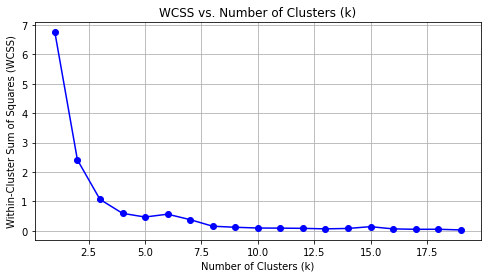

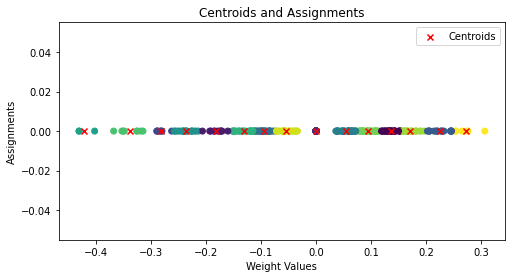

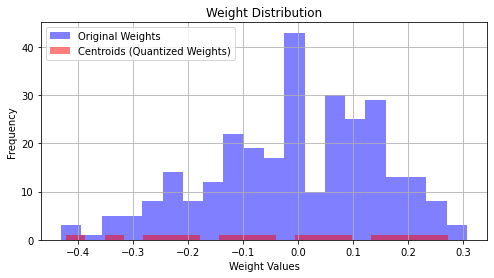

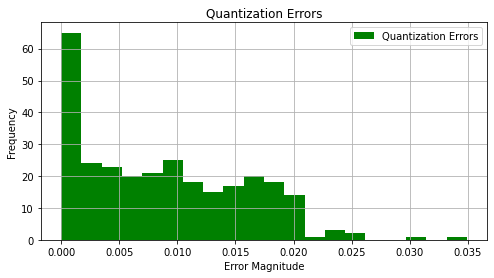

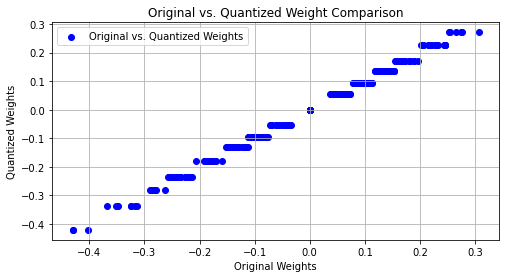

DENSITY BASED INITIALISATION OF CENTROIDS
WCSS for k = 1 is 6.751110076904297
WCSS for k = 2 is 2.4092931747436523
WCSS for k = 3 is 1.0656503438949585
WCSS for k = 4 is 0.6896063685417175
WCSS for k = 5 is 0.3981372117996216
WCSS for k = 6 is 0.2978321611881256
WCSS for k = 7 is 0.19357812404632568
WCSS for k = 8 is 0.17002935707569122
WCSS for k = 9 is 0.11658662557601929
WCSS for k = 10 is 0.12256449460983276
WCSS for k = 11 is 0.07910512387752533
WCSS for k = 12 is 0.070148766040802
WCSS for k = 13 is 0.06957423686981201
WCSS for k = 14 is 0.04958463832736015
WCSS for k = 15 is 0.043583326041698456
WCSS for k = 16 is 0.03799573332071304
WCSS for k = 17 is 0.037191543728113174
WCSS for k = 18 is 0.025533001869916916
WCSS for k = 19 is 0.02511059120297432


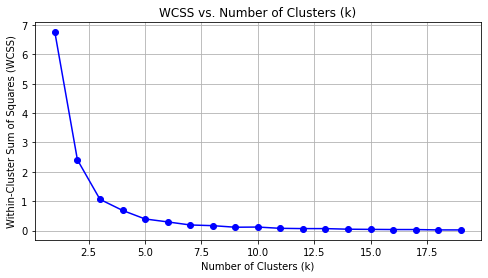

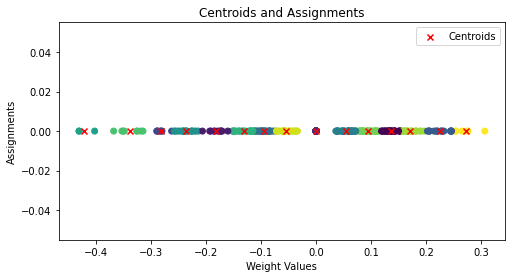

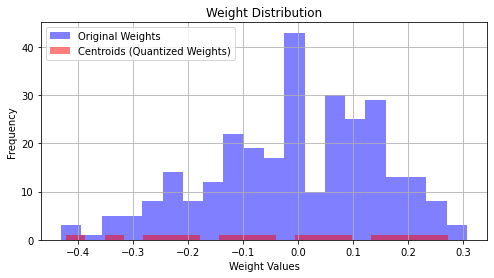

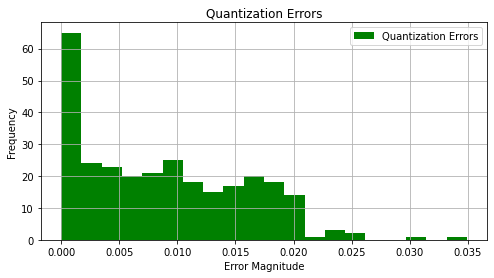

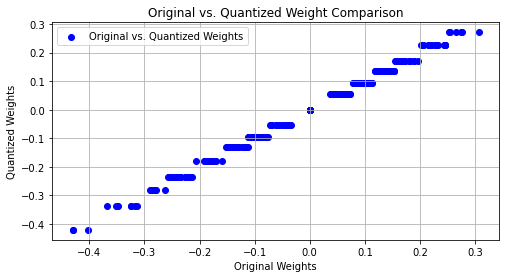

LINEAR BASED INITIALISATION OF CENTROIDS
WCSS for k = 1 is 6.751110076904297
WCSS for k = 2 is 2.132795810699463
WCSS for k = 3 is 1.0693612098693848
WCSS for k = 4 is 0.5931010842323303
WCSS for k = 5 is 0.40024974942207336
WCSS for k = 6 is 0.28643345832824707
WCSS for k = 7 is 0.22017782926559448
WCSS for k = 8 is 0.1669284701347351
WCSS for k = 9 is 0.1270265132188797
WCSS for k = 10 is 0.10545229911804199
WCSS for k = 11 is 0.09322314709424973
WCSS for k = 12 is 0.08221267908811569
WCSS for k = 13 is 0.05718022584915161
WCSS for k = 14 is 0.05119761452078819
WCSS for k = 15 is 0.046855226159095764
WCSS for k = 16 is 0.0390939861536026
WCSS for k = 17 is 0.031491175293922424
WCSS for k = 18 is 0.029429316520690918
WCSS for k = 19 is 0.027197500690817833


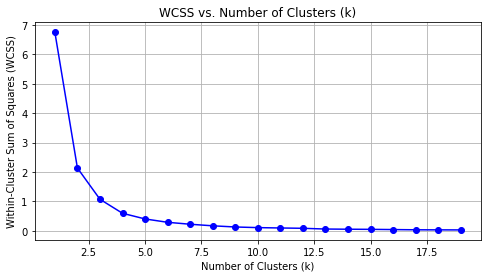

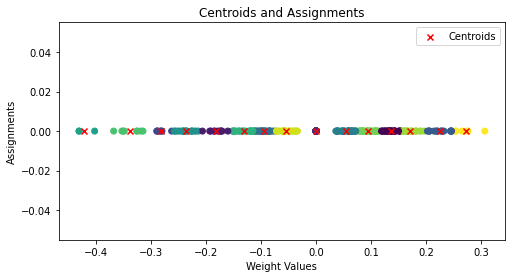

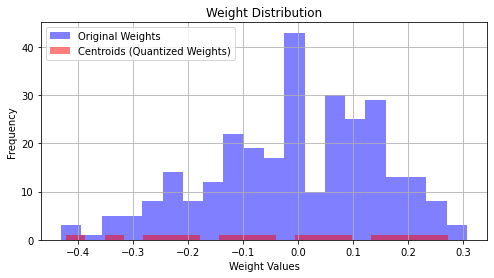

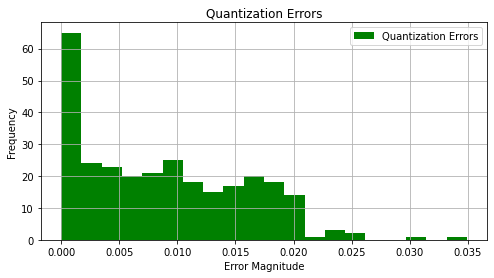

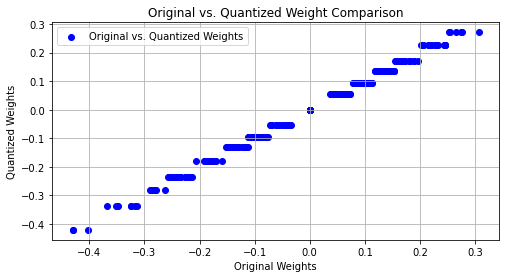

[[[[-0.23408599 -0.18493393  0.17310843  0.10935644  0.14332195
     0.130776    0.2529812  -0.          0.12103167  0.16496311
    -0.21354975 -0.2261392  -0.08516283 -0.11210348  0.12377248
     0.         -0.14031564 -0.          0.14261845 -0.28259444
     0.15443373  0.0780115   0.         -0.07935287 -0.
    -0.19075225  0.          0.07269405 -0.06083256 -0.11047336
    -0.17327973 -0.15186234]]

  [[-0.352221    0.13494387  0.08046485  0.05779601  0.17183338
     0.04031592  0.08633646 -0.         -0.          0.093862
    -0.42991728 -0.05918447 -0.05653796  0.21401836  0.16674766
     0.2459062   0.06191484 -0.13354845  0.09630499 -0.08312252
     0.13191608  0.16088867  0.11243138  0.08291129  0.08162419
     0.06570818 -0.4017007  -0.10647263 -0.10240225 -0.11857539
     0.          0.0497089 ]]

  [[-0.1382319  -0.          0.24459548 -0.25601998  0.23218422
    -0.06958496 -0.28781587 -0.32523957 -0.04404368  0.
    -0.          0.1886314   0.          0.04033781  0.08620

In [11]:
import numpy as np
import warnings
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
# matrix_1st matrix_2nd
# Define centroid initialization methods
def random_init(X, k):
    # Randomly choose k observations from the data set as initial centroids
    initial_centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    return initial_centroids

def density_based_init(X, k):
    # Linearly space the CDF of the data and find the corresponding quantiles
    percentiles = np.linspace(0, 100, k + 2)[1:-1]
    initial_centroids = np.percentile(X, percentiles)
    return initial_centroids

def linear_init(X, k):
    # Linearly space the centroids between the min and max values of the data
    initial_centroids = np.linspace(np.min(X), np.max(X), k)
    return initial_centroids

# Custom initialization wrapper
def custom_init(X, k, method):
    if method == 'random':
        return random_init(X, k)
    elif method == 'density_based':
        return density_based_init(X, k)
    elif method == 'linear':
        return linear_init(X, k)
    else:
        raise ValueError("Invalid centroid initialization method")

# Step 3: Implement weight sharing using K-means clustering with WCSS for k selection
def weight_sharing_with_optimal_k(layer_weights, centroid_init_method='random'):
    # Reshape the weights into a 1D array

    flattened_weights = layer_weights.flatten()

    # Initialize a list to store WCSS values for different values of k
    wcss = []

    # Define a range of values for k (number of clusters)
    k_values = range(1, 20)  # You can adjust the range as needed

    # Calculate WCSS for each k
    for k in k_values:
        # Use the custom_init wrapper to select the initialization method
        initial_centroids = custom_init(flattened_weights.reshape(-1, 1), k, centroid_init_method)
        kmeans = KMeans(n_clusters=k, random_state=0, init=initial_centroids.reshape(-1, 1))
        kmeans.fit(flattened_weights.reshape(-1, 1))
        wcss.append(kmeans.inertia_)
        print('WCSS for k = '+ str(k)+' is ' + str(kmeans.inertia_))


    # Plot the WCSS values to select the optimal k
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
    plt.title('WCSS vs. Number of Clusters (k)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.grid()
    plt.show()

    # Choose the optimal k (e.g., by visually inspecting the elbow point)
    optimal_k = 15 # Replace with your chosen optimal k

    # Apply K-means clustering with the chosen optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    kmeans.fit(flattened_weights.reshape(-1, 1))

    # Get cluster assignments for each weight
    cluster_assignments = kmeans.predict(flattened_weights.reshape(-1, 1))

    # Create shared centroids
    centroids = kmeans.cluster_centers_.flatten()

    # Reshape cluster assignments back to the original shape
    shared_weights = centroids[cluster_assignments].reshape(layer_weights.shape)

    # Plot centroids and their assignments
    plt.figure(figsize=(8, 4))
    plt.scatter(flattened_weights, np.zeros_like(flattened_weights), c=cluster_assignments, cmap='viridis')
    plt.scatter(centroids, np.zeros_like(centroids), c='red', marker='x', label='Centroids')
    plt.title('Centroids and Assignments')
    plt.xlabel('Weight Values')
    plt.ylabel('Assignments')
    plt.legend()
    plt.show()

        # Plot weight distribution histogram
    plt.figure(figsize=(8, 4))
    plt.hist(flattened_weights, bins=20, alpha=0.5, color='blue', label='Original Weights')
    plt.hist(centroids, bins=20, alpha=0.5, color='red', label='Centroids (Quantized Weights)')
    plt.title('Weight Distribution')
    plt.xlabel('Weight Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate errors between original weights and quantized centroids
    quantization_errors = np.abs(flattened_weights - centroids[cluster_assignments])

    # Plot error distribution histogram
    plt.figure(figsize=(8, 4))
    plt.hist(quantization_errors, bins=20, color='green', label='Quantization Errors')
    plt.title('Quantization Errors')
    plt.xlabel('Error Magnitude')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()


    # Plot original vs. quantized weight comparison
    plt.figure(figsize=(8, 4))
    plt.scatter(flattened_weights, centroids[cluster_assignments], color='blue', label='Original vs. Quantized Weights')
    plt.title('Original vs. Quantized Weight Comparison')
    plt.xlabel('Original Weights')
    plt.ylabel('Quantized Weights')
    plt.legend()
    plt.grid()
    plt.show()





    return shared_weights, centroids

# Step 4: Quantize the weights and store them in shared centroids
def quantize_weights(layer_weights, centroids):
    # Quantize the weights by finding the closest centroid for each weight
    quantized_weights = centroids[np.argmin(np.abs(layer_weights.reshape(-1, 1) - centroids), axis=1)]

    # Reshape quantized weights back to the original shape
    quantized_weights = quantized_weights.reshape(layer_weights.shape)

    return quantized_weights

# Step 6: During inference, use the shared centroids for forward propagation
def forward_propagation(input_data, shared_weights):
    output = np.dot(input_data, shared_weights)
    return output

input_size = 5
hidden_size = 5

layer_weights=matrix_1st[0]


print("RANDOM INITIALISATION OF CENTROIDS")

shared_weights_random, centroids_random = weight_sharing_with_optimal_k(layer_weights, centroid_init_method='random')


print("DENSITY BASED INITIALISATION OF CENTROIDS")

# Density-based initialization
shared_weights_density, centroids_density = weight_sharing_with_optimal_k(layer_weights, centroid_init_method='density_based')


print("LINEAR BASED INITIALISATION OF CENTROIDS")
# Linear initialization
shared_weights_linear, centroids_linear = weight_sharing_with_optimal_k(layer_weights, centroid_init_method='linear')

print(layer_weights)
print(shared_weights_linear)




In [12]:
import numpy as np
import warnings
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load the model from the .h5 file
quantized_model = load_model('Pruned_Alexnet_MNIST.h5')


warnings.filterwarnings('ignore')
centroids=[];
quantized_weights=[];
# matrix_1st matrix_2nd
# Define centroid initialization methods
def random_init(X, k):
    # Randomly choose k observations from the data set as initial centroids
    initial_centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    return initial_centroids

def density_based_init(X, k):
    # Linearly space the CDF of the data and find the corresponding quantiles
    percentiles = np.linspace(0, 100, k + 2)[1:-1]
    initial_centroids = np.percentile(X, percentiles)
    return initial_centroids

def linear_init(X, k):
    # Linearly space the centroids between the min and max values of the data
    initial_centroids = np.linspace(np.min(X), np.max(X), k)
    return initial_centroids

# Custom initialization wrapper
def custom_init(X, k, method):
    if method == 'random':
        return random_init(X, k)
    elif method == 'density_based':
        return density_based_init(X, k)
    elif method == 'linear':
        return linear_init(X, k)
    else:
        raise ValueError("Invalid centroid initialization method")

# Step 3: Implement weight sharing using K-means clustering with WCSS for k selection
def weight_sharing_with_optimal_k(layer_weights, centroid_init_method='random'):
    # Reshape the weights into a 1D array

    flattened_weights = layer_weights.flatten()

    # Initialize a list to store WCSS values for different values of k
    wcss = []

    # Define a range of values for k (number of clusters)
    k_values = range(1, 20)  # You can adjust the range as needed

    # Calculate WCSS for each k
    for k in k_values:
        # Use the custom_init wrapper to select the initialization method
        initial_centroids = custom_init(flattened_weights.reshape(-1, 1), k, centroid_init_method)
        kmeans = KMeans(n_clusters=k, random_state=0, init=initial_centroids.reshape(-1, 1))
        kmeans.fit(flattened_weights.reshape(-1, 1))
        wcss.append(kmeans.inertia_)

    # Choose the optimal k (e.g., by visually inspecting the elbow point)
    optimal_k = 15 # Replace with your chosen optimal k

    # Apply K-means clustering with the chosen optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=0)
    kmeans.fit(flattened_weights.reshape(-1, 1))

    # Get cluster assignments for each weight
    cluster_assignments = kmeans.predict(flattened_weights.reshape(-1, 1))

    # Create shared centroids
    centroids = kmeans.cluster_centers_.flatten()

    # Reshape cluster assignments back to the original shape
    shared_weights = centroids[cluster_assignments].reshape(layer_weights.shape)


    return shared_weights, centroids

# Step 4: Quantize the weights and store them in shared centroids
def quantize_weights(layer_weights, centroids):
    # Quantize the weights by finding the closest centroid for each weight
    quantized_weights = centroids[np.argmin(np.abs(layer_weights.reshape(-1, 1) - centroids), axis=1)]

    # Reshape quantized weights back to the original shape
    quantized_weights = quantized_weights.reshape(layer_weights.shape)

    return quantized_weights

# Step 6: During inference, use the shared centroids for forward propagation
def forward_propagation(input_data, shared_weights):
    output = np.dot(input_data, shared_weights)
    return output
k=-1;
# print(len(model.layers))
for matrix in matrix_1st:
  k+=1;
  layer_weights=np.array(matrix)

  if(layer_weights.size<=20):
    continue;
    # centroids.append(layer_weights);
    # quantized_weights.append(layer_weights);


  temp=layer_weights.shape;
#   print(layer_weights.shape)
  # Linear initialization
  shared_weights_linear, centroids_linear = weight_sharing_with_optimal_k(layer_weights, centroid_init_method='linear')
  centroids.append(centroids_linear);
  quantized_weights.append(shared_weights_linear);
#   print(k)
  # print(model.layers[k].get_weights()[1])
  # print("hi")
  if(k!=1 and k!=3 and k!=5 and k!=7):
    quantized_model.layers[k].set_weights([shared_weights_linear.reshape(temp), quantized_model.layers[k].get_weights()[1]])
#   else :
#       print(layer_weights.shape)

  # print(layer_weights)
  # print(shared_weights_linear)

quantized_model.save('quantized_alex_mnist.h5')
# print(centroids)
# print(quantized_weights)


# Load the saved model
pruned_model = load_model('Pruned_Alexnet_MNIST.h5')

# Compile the model with the same configuration as when it was trained
# Make sure to specify the appropriate metrics (e.g., 'accuracy') in compile
# pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# Load your test data (X_test, y_test)
# Replace X_test and y_test with your actual test data

# Evaluate the model on the test data
loss, accuracy = pruned_model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

# quantized_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
quantized_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

313/313 [==============================] - 3s 8ms/step - loss: 0.0256 - accuracy: 0.9923
Test loss: 0.025570165365934372
Test accuracy: 0.9922999739646912
313/313 [==============================] - 3s 8ms/step - loss: 0.0263 - accuracy: 0.9919
Test loss: 0.026326708495616913
Test accuracy: 0.9919000267982483


In [13]:
#centroids , quantized_weights
file_path = "Alexnet_MNIST.txt"

with open(file_path, "w") as file:
    for row in quantized_weights:
        # Convert each element to a string and join them with spaces
        row_str = " ".join(map(str, row))

        # Write the row to the file
        file.write(row_str + "\n")

In [14]:
quantized_weights_flatten=[]
for i in quantized_weights:
    quantized_weights_flatten.append(i.flatten())

In [15]:
# print(len(shared_weights_density_flatten_list))
strings=[]
for j in range(len(quantized_weights_flatten)):
    s=""
    for i in range(len(quantized_weights_flatten[j])):
        if(quantized_weights_flatten[j][i]==centroids[j][0]):
            s = s+"A"
        if(quantized_weights_flatten[j][i]==centroids[j][1]):
            s = s+"B"
        if(quantized_weights_flatten[j][i]==centroids[j][2]):
            s = s+"C"
        if(quantized_weights_flatten[j][i]==centroids[j][3]):
            s = s+"D"
        if(quantized_weights_flatten[j][i]==centroids[j][4]):
            s = s+"E"
        if(quantized_weights_flatten[j][i]==centroids[j][5]):
            s = s+"F"
        if(quantized_weights_flatten[j][i]==centroids[j][6]):
            s = s+"G"
        if(quantized_weights_flatten[j][i]==centroids[j][7]):
            s = s+"H"
        if(quantized_weights_flatten[j][i]==centroids[j][8]):
            s = s+"I"
        if(quantized_weights_flatten[j][i]==centroids[j][9]):
            s = s+"J"
        if(quantized_weights_flatten[j][i]==centroids[j][10]):
            s = s+"K"
        if(quantized_weights_flatten[j][i]==centroids[j][11]):
            s = s+"L"
        if(quantized_weights_flatten[j][i]==centroids[j][12]):
            s = s+"M"
        if(quantized_weights_flatten[j][i]==centroids[j][13]):
            s = s+"N"
        if(quantized_weights_flatten[j][i]==centroids[j][14]):
            s = s+"O"
    strings.append(s)

In [16]:
from collections import Counter, namedtuple

# Define a named tuple to represent a Huffman tree node
HuffmanNode = namedtuple("HuffmanNode", ["char", "freq", "left", "right"])

# Function to build the Huffman tree
def build_huffman_tree(text):
    char_freq = Counter(text)
    priority_queue = [HuffmanNode(char, freq, None, None) for char, freq in char_freq.items()]
    while len(priority_queue) > 1:
        priority_queue.sort(key=lambda node: node.freq)
        left = priority_queue.pop(0)
        right = priority_queue.pop(0)
        merged_node = HuffmanNode(None, left.freq + right.freq, left, right)
        priority_queue.append(merged_node)
    return priority_queue[0]

# Function to generate Huffman codes
def generate_huffman_codes(root, current_code="", code_dict=None):
    if code_dict is None:
        code_dict = {}
    if root.char is not None:
        code_dict[root.char] = current_code
    if root.left is not None:
        generate_huffman_codes(root.left, current_code + "0", code_dict)
    if root.right is not None:
        generate_huffman_codes(root.right, current_code + "1", code_dict)
    return code_dict

# Function to perform Huffman encoding
def huffman_encode(text):
    root = build_huffman_tree(text)
    code_dict = generate_huffman_codes(root)
    encoded_text = "".join(code_dict[char] for char in text)
    return encoded_text, root

# Function to perform Huffman decoding
def huffman_decode(encoded_text, root):
    decoded_text = ""
    current_node = root
    for bit in encoded_text:
        if bit == "0":
            current_node = current_node.left
        else:
            current_node = current_node.right

        if current_node.char is not None:
            decoded_text += current_node.char
            current_node = root

    return decoded_text

# text = s
# encoded_text, tree = huffman_encode(text)
# decoded_text = huffman_decode(encoded_text, tree)

# print("Original text:", text)
# print("Encoded text:", encoded_text)
# print("Decoded text:", decoded_text)

In [17]:
# Encode all the matrixes
encoded_texts=[]
huffman_tree=[]
for i in range(len(quantized_weights)):
    encoded_text,tree = huffman_encode(strings[i])
    encoded_texts.append(encoded_text)
    huffman_tree.append(tree)

In [18]:
# For Alexnet on MNIST dataset
file_path = "Alexnet_MNIST_huffman.txt"

with open("Alexnet_MNIST_huffman.txt", "w") as file:
    for row in encoded_texts:
        # Write the row to the file
        file.write(row + "\n")

In [19]:
import h5py
import numpy as np

# Define the input text file and output HDF5 file names
input_txt_file = "Alexnet_MNIST_huffman.txt"
output_h5_file = "Alexnet_MNIST_huffman.h5"

# Read data from the text file (assuming each line contains a numerical value)
with open(input_txt_file, "r") as txt_file:
    data = [float(line.strip()) for line in txt_file]

# Convert the data to a NumPy array
data_array = np.array(data)

# Create an HDF5 file and save the data
with h5py.File(output_h5_file, "w") as h5_file:
    h5_file.create_dataset("data", data=data_array)

In [22]:
import os

file_path_1 = "Alexnet_MNIST.h5"  # Replace with the path to your file
file_size_1 = os.path.getsize(file_path_1)
print(f"The size of '{file_path_1}' is {file_size_1} bytes")

file_path_2 = "Pruned_Alexnet_MNIST.h5"
file_size_2 = os.path.getsize(file_path_2)
print(f"The size of '{file_path_2}' is {file_size_2} bytes")

file_path_3 = "Alexnet_MNIST_huffman.h5"
file_size_3 = os.path.getsize(file_path_3)
print(f"The size of '{file_path_3}' is {file_size_3} bytes")

The size of 'Alexnet_MNIST.h5' is 2952320 bytes
The size of 'Pruned_Alexnet_MNIST.h5' is 996936 bytes
The size of 'Alexnet_MNIST_huffman.h5' is 2120 bytes
